In [ ]:
!pip install keras_vggface
!pip install keras_applications

     |████████████████████████████████| 51kB 3.0MB/s 


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras_vggface.vggface import VGGFace
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
os.chdir("../content/drive/My Drive")

# Data Preprocessing

In [ ]:
data = pd.read_csv('datasets/raw/fer2013.csv').rename(columns={"Usage": "usage", "pixels": "pixel"})
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [ ]:
data["emotion"].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [ ]:
data["usage"].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: usage, dtype: int64

In [ ]:
train = data[data['usage'] == 'Training'][['pixel','emotion']].copy()
test = data[data['usage'] == 'PublicTest'][['pixel','emotion']].copy()
valid = data[data['usage'] == 'PrivateTest'][['pixel','emotion']].copy()

train['pixel'] = [np.fromstring(pix, dtype=int, sep=' ') for pix in train.pixel]
test['pixel'] = [np.fromstring(pix, dtype=int, sep=' ') for pix in test.pixel]
valid['pixel'] = [np.fromstring(pix, dtype=int, sep=' ') for pix in valid.pixel]

In [ ]:
def prepare_data(df, predictor, label):
  feature = np.array([img.reshape(48, 48) for img in df[predictor]])
  className = np.array(list(map(int, df[label])))
  return feature, className

In [ ]:
X_train, y_train = prepare_data(train, 'pixel', 'emotion')
X_test, y_test = prepare_data(test, 'pixel', 'emotion')
X_valid, y_valid = prepare_data(valid, 'pixel', 'emotion')

# EDA

In [ ]:
index = np.random.choice(X_train.shape[0], 5, replace=False) 

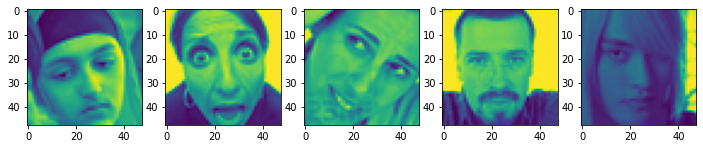

In [ ]:
fig, ax = plt.subplots(1, 5, figsize = (12,8))

for i in range(len(index)):
  ax[i].imshow(X_train[index[i]].reshape(48,48))
  pass

# Data Storage

In [ ]:
data = pd.read_csv('datasets/raw/fer2013.csv')

In [ ]:
data[data['Usage'] == "PrivateTest"].reset_index(drop = True)['emotion'].to_csv(path_or_buf = "datasets/privatetestlabel.csv", index_label = "id")
data[data['Usage'] == "PublicTest"].reset_index(drop = True)['emotion'].to_csv(path_or_buf = "datasets/publictestlabel.csv", index_label = "id")
data[data['Usage'] == "Training"].reset_index(drop = True)['emotion'].to_csv(path_or_buf = "datasets/traininglabel.csv", index_label = "id")

In [ ]:
def append_ext(fn):
    return fn+".jpg"

In [ ]:
def label_and_dir():
    train_label = pd.read_csv('datasets/traininglabel.csv',dtype=str)
    valid_label = pd.read_csv('datasets/publictestlabel.csv',dtype=str)
    test_label = pd.read_csv('datasets/privatetestlabel.csv',dtype=str)
    
    train_label["id"]=train_label["id"].apply(append_ext)
    valid_label["id"]=valid_label["id"].apply(append_ext)
    test_label["id"]=test_label["id"].apply(append_ext)
    
    # Define our example directories and files
    train_dir = 'datasets/Training'
    valid_dir = 'datasets/PublicTest'
    test_dir = 'datasets/PrivateTest'
    return train_dir, valid_dir, test_dir, train_label, valid_label, test_label

In [ ]:
import errno
import imageio

# initialization
image_height = 48
image_width = 48
window_size = 24
window_step = 6
SAVE_IMAGES = True
SELECTED_LABELS = [0,1,2,3,4,5,6]
IMAGES_PER_LABEL = 500
OUTPUT_FOLDER_NAME = "datasets"

original_labels = [0, 1, 2, 3, 4, 5, 6]
new_labels = list(set(original_labels) & set(SELECTED_LABELS))
nb_images_per_label = list(np.zeros(len(new_labels), 'uint8'))

try:
    os.makedirs(OUTPUT_FOLDER_NAME)
except OSError as e:
    if e.errno == errno.EEXIST and os.path.isdir(OUTPUT_FOLDER_NAME):
        pass
    else:
        raise

In [ ]:
for category in data['Usage'].unique():
    if category == "Training" or category == "PublicTest":
      continue
    print( "converting set: " + category + "...")
    # create folder
    if not os.path.exists(category):
        try:
            os.makedirs(OUTPUT_FOLDER_NAME + '/' + category)
        except OSError as e:
            if e.errno == errno.EEXIST and os.path.isdir(OUTPUT_FOLDER_NAME):
                pass
            else:
                raise
        
    # get samples and labels of the actual category
    category_data = data[data['Usage'] == category]
    samples = category_data['pixels'].values
    labels = category_data['emotion'].values
        
    # get images and extract features
    images = []
    labels_list = []
    landmarks = []
    hog_features = []
    hog_images = []
    for i in range(len(samples)):
        try:
            if labels[i] in SELECTED_LABELS: 
                image = np.fromstring(samples[i], dtype=int, sep=" ").astype(np.uint8).reshape((image_height, image_width))
                images.append(image)
                imageio.imwrite(OUTPUT_FOLDER_NAME + '/' + category + '/' + str(i) + '.jpg', image)
                    
        except Exception as e:
            print( "error in image: " + str(i) + " - " + str(e))
    
    np.save(OUTPUT_FOLDER_NAME + '/' + category + '/images.npy', images)

converting set: PrivateTest...


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def data_generator(train_dir, valid_dir, test_dir, train_label, valid_label, test_label):
    # Add our data-augmentation parameters to ImageDataGenerator
    train_datagen = ImageDataGenerator(#rescale = 1./255.,
                                       rotation_range = 40,
                                       width_shift_range = 0.2,
                                       height_shift_range = 0.2,
                                       shear_range = 0.2,
                                       zoom_range = 0.2,
                                       horizontal_flip = True)
    
    # Note that the validation data should not be augmented!
    valid_datagen = ImageDataGenerator()#rescale = 1./255. )
    test_datagen = ImageDataGenerator()#rescale = 1./255. )
    
    # Flow training images in batches of 5 using train_datagen generator
    train_generator=train_datagen.flow_from_dataframe(dataframe=train_label,
                                                     directory=train_dir,
                                                     x_col="id",
                                                     y_col="emotion",
                                                     target_size=(96,96),
                                                     batch_size=32,
                                                     seed=42,
                                                     shuffle=True,
                                                     class_mode="categorical",
                                                     color_mode='rgb')
    
    # # Flow validation images in batches of 5 using test_datagen generator
    valid_generator=valid_datagen.flow_from_dataframe(dataframe=valid_label,
                                                      directory=valid_dir,
                                                      x_col="id",
                                                      y_col="emotion",
                                                      target_size=(96,96),
                                                      batch_size=32,
                                                      seed=42,
                                                      shuffle=True,
                                                      class_mode="categorical",
                                                      color_mode='rgb')
    
    # Flow validation images in batches of 5 using test_datagen generator
    test_generator=test_datagen.flow_from_dataframe(dataframe=test_label,
                                                     directory=test_dir,
                                                     x_col="id",
                                                     y_col=None,
                                                     target_size=(96,96),
                                                     batch_size=32,
                                                     seed=42,
                                                     shuffle=False,
                                                     class_mode=None,
                                                     color_mode='rgb')
    return train_generator, valid_generator, test_generator

# Model Fitting

In [ ]:
train_dir, valid_dir, test_dir, train_label, valid_label, test_label = label_and_dir()
train_generator, valid_generator, test_generator = data_generator(train_dir, valid_dir, test_dir, train_label, valid_label, test_label)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 28708 validated image filenames belonging to 7 classes.
Found 3589 validated image filenames belonging to 7 classes.
Found 3589 validated image filenames.


In [ ]:
nb_class = 7
hidden_dim = 512

#Creating a VGGFace model instance.
vgg_model = VGGFace(include_top=False, input_shape=(96, 96, 3))#weights=None

#Use the architecture of the VGGFace and append a fully connected layer with 512 neurons before the final classification using softmax.
last_layer = vgg_model.get_layer('pool5').output
x = layers.Flatten()(last_layer)
x = layers.Dense(hidden_dim, activation='relu', name='fc7')(x)
x = layers.Dense(nb_class, activation='softmax', name='fc8')(x)
custom_vgg_model = Model(vgg_model.input, x)

#Printing the model summary
custom_vgg_model.summary()

# Training the model
custom_vgg_model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.0001),
              metrics=['accuracy'])

58916864/58909280 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 96, 96, 64)        1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 96, 96, 64)        36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 48, 48, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 48, 48, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 48, 48, 128)       147584    
______________________________________________________________

In [ ]:
from keras.callbacks import EarlyStopping

early = EarlyStopping(monitor='val_accuracy', min_delta=0.00005, patience=20, verbose=1, mode='auto')

In [ ]:
history = custom_vgg_model.fit(
            train_generator,
            validation_data = valid_generator,
            steps_per_epoch = 435,
            epochs = 100,
            validation_steps = 55,
            verbose = 2,
            callbacks=[early])

custom_vgg_model.save("best_non_pretrained.h5")

Epoch 1/100


# Predict test generator

In [ ]:
from tensorflow import keras

model = keras.models.load_model("best_all.h5")

In [ ]:
pred = model.predict(test_generator, steps=1)

# Predict static image

In [ ]:
cd datasets/PrivateTest/

/content/drive/My Drive/datasets/PrivateTest


In [ ]:
import cv2

faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def face_crop(picName, id):
  faces = faceCascade.detectMultiScale(
          picName,
          scaleFactor=1.3,
          minNeighbors=3,
          minSize=(30, 30)
  )

  print("Found {0} Faces!".format(len(faces)))
  for (x, y, w, h) in faces:
    cv2.rectangle(jammie, (x, y), (x+w, y+h), (0, 255, 0), 2)
  
  status = cv2.imwrite('faces_detected_' + id + '.jpg', picName)
  print(f"[INFO] Image faces_detected_{id}.jpg written to filesystem: ", status)

In [ ]:
imgs = [str(num) + '.jpg' for num in range(3589)] #3589
cropped = []

for i, img in enumerate(imgs):
  face_crop(img, i)
  pic = cv2.imread('face_detected_' + img)
  pics.append(pic)

Example Output

In [ ]:
imgs = ['faces_detected_' + str(num) + '.jpg' for num in range(10)]

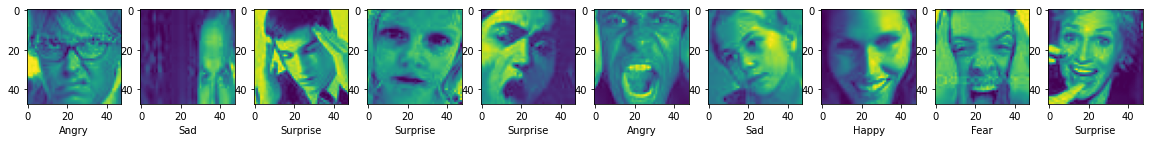

In [ ]:
import matplotlib.image as mpimg

fig, ax = plt.subplots(1, 10, figsize = (20,18))

for i in range(10):
  img = mpimg.imread(imgs[i])
  ax[i].imshow(img)
  #ax[i].axis('off')
  ax[i].set_xlabel(results[i])
  pass

My personal Image - Sad

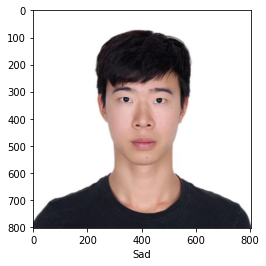

In [ ]:
img = mpimg.imread('pic.jpg')
plt.imshow(img)
plt.xlabel(emotions[np.where(preds == preds.max())[1][0]])
plt.show()

In [ ]:
img = image.load_img('pic.jpg', target_size=(96, 96))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=1) # or version=2

preds = model.predict(x)
print(emotions[np.where(preds == preds.max())[1][0]])

Sad


All the output

In [ ]:
imgs = [str(num) + '.jpg' for num in range(3589)] #3589

In [ ]:
from keras_vggface import utils
from keras.preprocessing import image
from time import time

results = []
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

elapsed_1 = []

for pic in imgs:
  img = image.load_img(pic, target_size=(96, 96))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = utils.preprocess_input(x, version=1) # or version=2

  start = time()
  preds = model.predict(x, batch_size=32)
  elapsed_1.append(time()-start)
  
  res = emotions[np.where(preds == preds.max())[1][0]]
  results.append(res)

In [ ]:
len(results)

3589

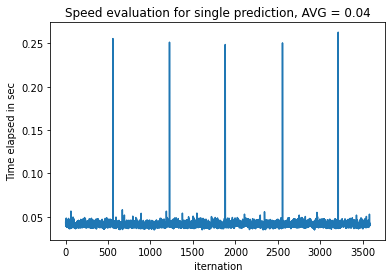

In [ ]:
plt.plot(elapsed_1)
plt.xlabel('iternation')
plt.ylabel('Time elapsed in sec')
plt.title(f'Speed evaluation for single prediction, AVG = {np.mean(elapsed_1):.02f}')
plt.show()

# Model Evaluation

In [ ]:
allout = [out.split(' - ') for out in new.split('\n')]

In [ ]:
newDict = {'loss':[], 'accuracy':[], 'val_loss':[], 'val_accuracy':[]}

for out in allout:
  for i in range(4):
    imm = out[i].split(': ')
    newDict[imm[0]].append(float(imm[1]))
    pass

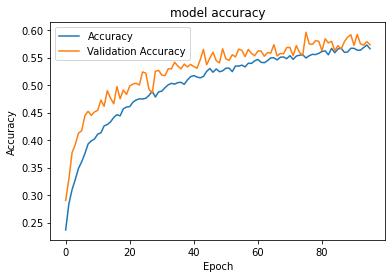

In [ ]:
plt.plot(newDict["accuracy"])
plt.plot(newDict['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

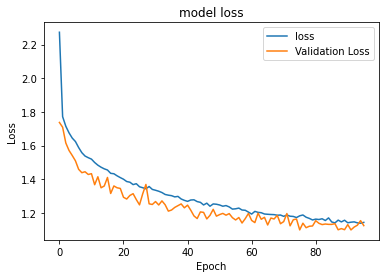

In [ ]:
plt.plot(newDict['loss'])
plt.plot(newDict['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

In [ ]:
emotions.values()

dict_values(['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])

In [ ]:
y_pred = results.copy()

for i in range(len(results)):
  y_pred[i] = int(list(emotions.values()).index(results[i]))
  pass
y_pred = np.array(y_pred)

In [ ]:
y_pred
#final = np.argmax(y_pred, axis=1)

array([0, 4, 5, ..., 4, 3, 4])

In [ ]:
y_test

array([0, 1, 4, ..., 4, 4, 4])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

matrix = confusion_matrix(y_test, y_pred)

In [ ]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

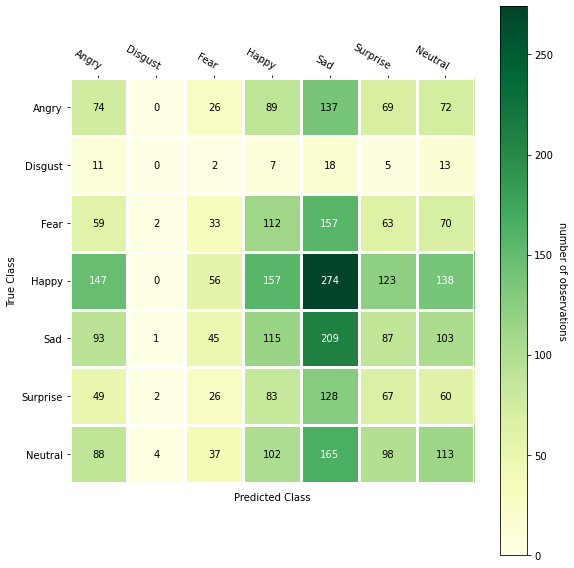

In [ ]:
import matplotlib

fig, ax = plt.subplots(figsize = (8, 8))

im, cbar = heatmap(matrix, list(emotions.values()), list(emotions.values()), ax=ax,
                   cmap="YlGn", cbarlabel="number of observations")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

fig.tight_layout()
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names=list(emotions.values())))

              precision    recall  f1-score   support

       Angry       0.14      0.16      0.15       467
     Disgust       0.00      0.00      0.00        56
        Fear       0.15      0.07      0.09       496
       Happy       0.24      0.18      0.20       895
         Sad       0.19      0.32      0.24       653
    Surprise       0.13      0.16      0.14       415
     Neutral       0.20      0.19      0.19       607

    accuracy                           0.18      3589
   macro avg       0.15      0.15      0.15      3589
weighted avg       0.18      0.18      0.18      3589



In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.18194483142936752

# Roc curve

In [ ]:
rocPred = model.predict(test_generator,
                                steps=test_generator.n//test_generator.batch_size,
                                verbose=1)



112/112 [==============================] - 6s 52ms/step


In [ ]:
np.argmax(rocPred,axis=1)

array([0, 4, 4, ..., 4, 5, 0])

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[i], y_pred[i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()